In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- CONFIGURATION ---
DETAILS_CSV = "wikipedia/experiments/run_20251129_183633/results/canary_details_full.csv"
ORIGINAL_CANARIES_CSV = "memorization/canaries_nosalt.csv" 

# --- HELPER FUNCTIONS ---
def calculate_dynamic_threshold(scores, fpr_target=0.10):
    if len(scores) == 0: return float('inf')
    return np.percentile(scores, (1 - fpr_target) * 100)

def analyze_subset_metrics(df_subset):
    stats = []
    epochs = sorted(df_subset['epoch'].unique())
    for epoch in epochs:
        df_epoch = df_subset[df_subset['epoch'] == epoch]
        val_data = df_epoch[df_epoch['split'] == 'validation']
        train_data = df_epoch[df_epoch['split'] == 'train']
        
        if len(val_data) == 0 or len(train_data) == 0: continue
            
        tau = calculate_dynamic_threshold(val_data['mia_score'].values, fpr_target=0.10)
        
        is_memorized = train_data['mia_score'] > tau
        mia_recall = is_memorized.sum() / len(train_data)
        avg_ctx = train_data['contextual_score'].mean()
        avg_cf = train_data['counterfactual_score'].mean()
        
        stats.append({
            'epoch': epoch, 'mia_recall': mia_recall, 
            'contextual_score': avg_ctx, 'counterfactual_score': avg_cf
        })
    return pd.DataFrame(stats)

def plot_comparison(df_stats, title):
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df_stats, x='epoch', y='mia_recall', label='MIA Recall', linewidth=3, marker='o', color='crimson')
    sns.lineplot(data=df_stats, x='epoch', y='counterfactual_score', label='Counterfactual', linewidth=2, linestyle='-.', marker='v', color='green', alpha=0.7)
    sns.lineplot(data=df_stats, x='epoch', y='contextual_score', label='Contextual', linewidth=3, linestyle='--', marker='s', color='royalblue')
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel("Training Epochs"); plt.ylabel("Score (0.0 - 1.0)"); plt.ylim(-0.05, 1.05)
    plt.legend(loc='lower right'); plt.grid(True, alpha=0.3); plt.show()

In [8]:
if not os.path.exists(DETAILS_CSV) or not os.path.exists(ORIGINAL_CANARIES_CSV):
    print("❌ ERROR: Files not found.")
else:
    print("✅ Loading files...")
    df_details = pd.read_csv(DETAILS_CSV)
    df_meta = pd.read_csv(ORIGINAL_CANARIES_CSV)

    # Merge to get 'type' column
    df_merged = pd.merge(df_details, df_meta[['canary_id', 'type']], on='canary_id', how='left')
    print(f"Merged Data Ready: {len(df_merged)} rows.")

✅ Loading files...
Merged Data Ready: 1200 rows.


Generating High Entropy Plot...


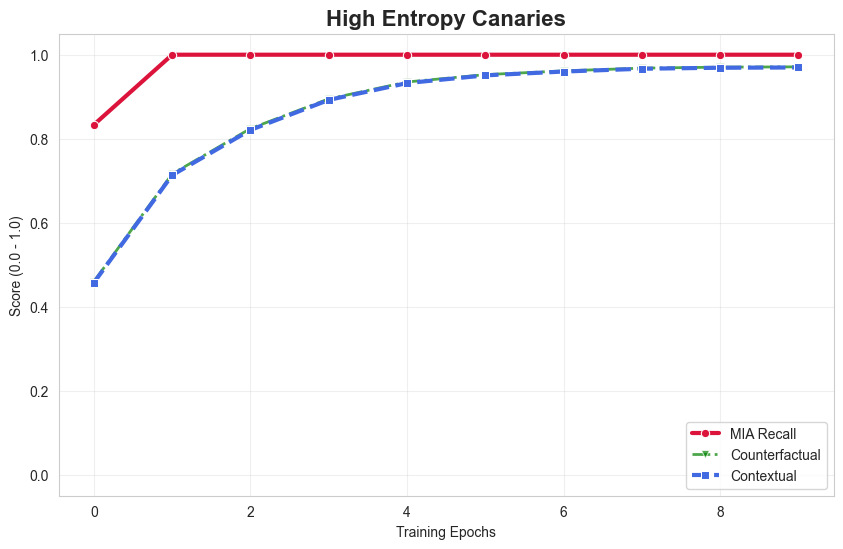

In [9]:
# --- PLOT 1: HIGH ENTROPY ---
df_high = df_merged[df_merged['type'] == 'high_entropy']
if not df_high.empty:
    print("Generating High Entropy Plot...")
    stats_high = analyze_subset_metrics(df_high)
    plot_comparison(stats_high, "High Entropy Canaries")


Generating Low Entropy Plot...


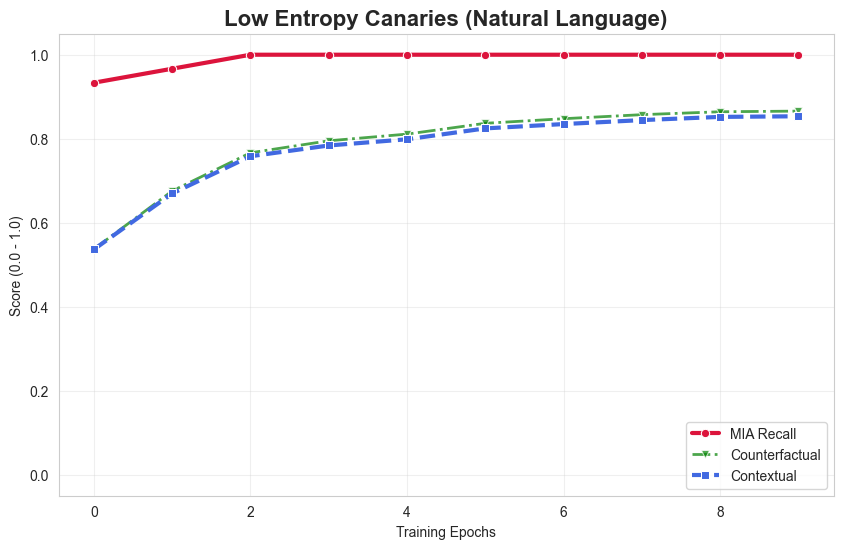

In [10]:
# --- PLOT 2: LOW ENTROPY ---
df_low = df_merged[df_merged['type'] == 'low_entropy']
if not df_low.empty:
    print("Generating Low Entropy Plot...")
    stats_low = analyze_subset_metrics(df_low)
    plot_comparison(stats_low, "Low Entropy Canaries (Natural Language)")

Loading Data...
Data Loaded Successfully. Generating Plots...


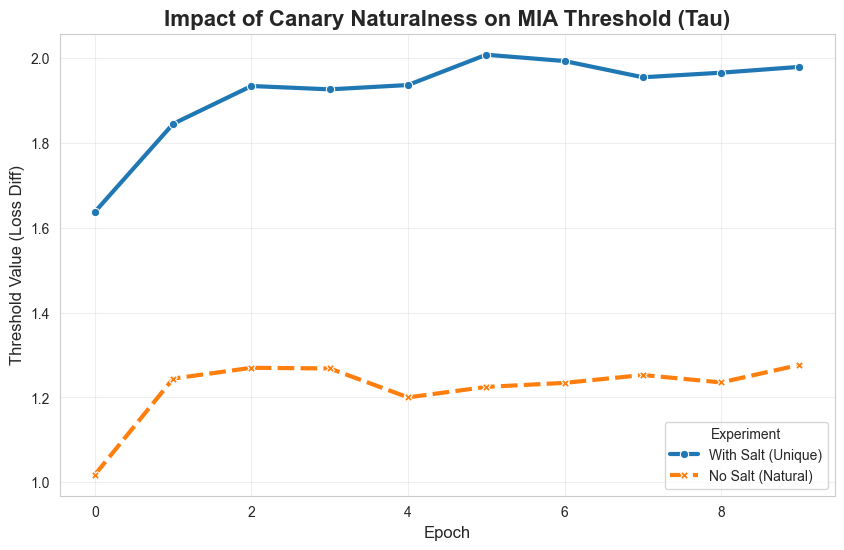

Plot 1: Shows that 'No Salt' requires a much lower threshold (harder to detect).


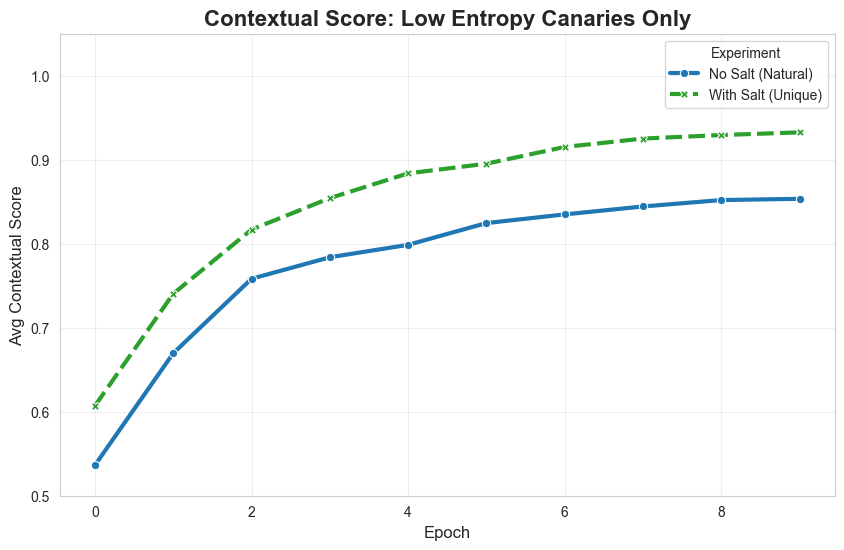

Plot 2: Shows that Contextual Score is LOWER for 'No Salt' (Correctly discounting general knowledge).


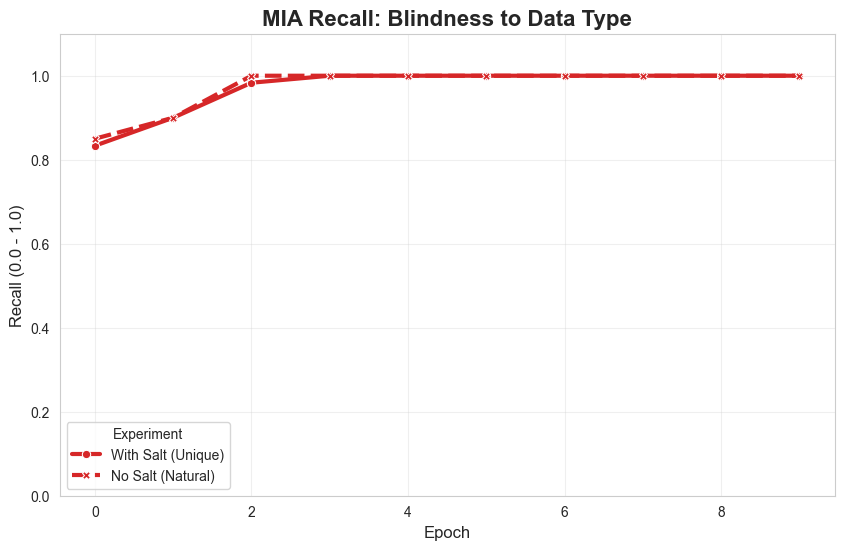

Plot 3: Shows that MIA Recall is 100% in both cases (Overestimation).


In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# ==============================================================================
# CONFIGURATION: UPDATE THESE PATHS!
# ==============================================================================

# 1. EXPERIMENT WITH SALT (High Uniqueness)
# Path to the folder containing 'results' and the original csv
DIR_SALT = "wikipedia/experiments/run_20251128_182313" 
META_SALT = "memorization/canaries.csv"

# 2. EXPERIMENT NO SALT (Natural Language)
# Path to the folder containing 'results' and the original csv
DIR_NOSALT = "wikipedia/experiments/run_20251129_183633" # <--- AGGIORNA QUESTO TIMESTAMP
META_NOSALT = "memorization/canaries_nosalt.csv"

# Output folder for plots
OUTPUT_DIR = "comparison_plots"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ==============================================================================
# DATA LOADING & PROCESSING
# ==============================================================================

def load_experiment_data(exp_dir, meta_file, label):
    """Loads summary and details, merges metadata, and tags the experiment."""
    
    summary_path = os.path.join(exp_dir, "results", "metrics_summary.csv")
    details_path = os.path.join(exp_dir, "results", "canary_details_full.csv")
    
    # Load CSVs
    if not os.path.exists(summary_path) or not os.path.exists(details_path):
        print(f"❌ ERROR: Files not found in {exp_dir}")
        return None, None

    df_summary = pd.read_csv(summary_path)
    df_details = pd.read_csv(details_path)
    df_meta = pd.read_csv(meta_file)
    
    # Tag the experiment
    df_summary['Experiment'] = label
    
    # Merge details with metadata to get 'type' (High/Low Entropy)
    df_details = pd.merge(df_details, df_meta[['canary_id', 'type']], on='canary_id', how='left')
    df_details['Experiment'] = label
    
    return df_summary, df_details

print("Loading Data...")
sum_salt, det_salt = load_experiment_data(DIR_SALT, META_SALT, "With Salt (Unique)")
sum_nosalt, det_nosalt = load_experiment_data(DIR_NOSALT, META_NOSALT, "No Salt (Natural)")

if sum_salt is None or sum_nosalt is None:
    print("Stopping due to missing files.")
else:
    # Combine Dataframes
    df_summary_all = pd.concat([sum_salt, sum_nosalt])
    df_details_all = pd.concat([det_salt, det_nosalt])
    
    # Filter only Low Entropy for the specific comparison
    df_low_entropy = df_details_all[
        (df_details_all['type'] == 'low_entropy') & 
        (df_details_all['split'] == 'train')
    ]
    # Calculate average Contextual Score for Low Entropy per epoch/experiment
    df_low_ctx = df_low_entropy.groupby(['epoch', 'Experiment'])['contextual_score'].mean().reset_index()

    print("Data Loaded Successfully. Generating Plots...")

    # ==============================================================================
    # PLOT 1: THE THRESHOLD DROP (Evidence of Naturalness)
    # ==============================================================================
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df_summary_all, x='epoch', y='mia_threshold_tau', hue='Experiment', 
                 style='Experiment', markers=True, linewidth=3, palette=['#1f77b4', '#ff7f0e'])
    
    plt.title("Impact of Canary Naturalness on MIA Threshold (Tau)", fontsize=16, fontweight='bold')
    plt.ylabel("Threshold Value (Loss Diff)", fontsize=12)
    plt.xlabel("Epoch", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.savefig(os.path.join(OUTPUT_DIR, "1_threshold_drop.png"), dpi=300)
    plt.show()
    print("Plot 1: Shows that 'No Salt' requires a much lower threshold (harder to detect).")

    # ==============================================================================
    # PLOT 2: CONTEXTUAL SCORE ON LOW ENTROPY (The Thesis Proof)
    # ==============================================================================
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df_low_ctx, x='epoch', y='contextual_score', hue='Experiment', 
                 style='Experiment', markers=True, linewidth=3, palette=['#1f77b4', '#2ca02c'])
    
    plt.title("Contextual Score: Low Entropy Canaries Only", fontsize=16, fontweight='bold')
    plt.ylabel("Avg Contextual Score", fontsize=12)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylim(0.5, 1.05) # Zoom in to see the gap
    plt.grid(True, alpha=0.3)
    plt.savefig(os.path.join(OUTPUT_DIR, "2_contextual_gap.png"), dpi=300)
    plt.show()
    print("Plot 2: Shows that Contextual Score is LOWER for 'No Salt' (Correctly discounting general knowledge).")

    # ==============================================================================
    # PLOT 3: MIA RECALL BLINDNESS
    # ==============================================================================
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df_summary_all, x='epoch', y='mia_recall', hue='Experiment', 
                 style='Experiment', markers=True, linewidth=3, palette=['#d62728', '#d62728']) # Both Red
    
    plt.title("MIA Recall: Blindness to Data Type", fontsize=16, fontweight='bold')
    plt.ylabel("Recall (0.0 - 1.0)", fontsize=12)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylim(0.0, 1.1)
    plt.grid(True, alpha=0.3)
    plt.savefig(os.path.join(OUTPUT_DIR, "3_mia_blindness.png"), dpi=300)
    plt.show()
    print("Plot 3: Shows that MIA Recall is 100% in both cases (Overestimation).")


